# Analysis of the Hierarchical Negative Binomial model with the CGC gene matrix covariate fit on the colorectal, pancreas, and esophagus sub-sampled data.

date: May 20, 2022

## Introduction

The latest version of the hierarchical negative binomial model was with the small sub-sample of colorectal, pancreas, and esophagus data.
This model includes a covariate for the mutation status of cancer genes, and the covariate is tissue-specific (i.e. "lineage"-specific in this case).
The model with fit with the standard PyMC sampler and with the Numpyro backend.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from time import time
from typing import Iterable

import arviz as az
import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc as pm

In [3]:
import speclet.plot.plotnine_helpers as sgg
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.hierarchical_nb import HierarchcalNegativeBinomialModel
from speclet.data_processing.common import head_tail
from speclet.io import DataFile, models_dir
from speclet.managers.data_managers import (
    CancerGeneDataManager,
    CrisprScreenDataManager,
)
from speclet.managers.posterior_summary_manager import PosteriorSummaryManager
from speclet.project_configuration import read_project_configuration
from speclet.project_enums import ModelFitMethod

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
sgg.set_theme_speclet()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)
HDI_PROB = read_project_configuration().modeling.highest_density_interval

## Data

### Create a model object

In [5]:
hnb_model = HierarchcalNegativeBinomialModel()

### Screen data

In [6]:
crispr_dm = CrisprScreenDataManager(DataFile.DEPMAP_CRC_PANC_ESO_SUBSAMPLE)
crispr_data = crispr_dm.get_data()
crispr_data.head()

sgrna                  replicate_id       lfc p_dna_batch  \
0  CGCCAAAATGACGAACACAA  LS513-311Cas9_RepA_p6_batch2  0.441730           2   
1  CTCGGACAGCACCCTCCCCG  LS513-311Cas9_RepA_p6_batch2 -1.495007           2   
2  GATCTGGTTTCAGAATCGAA  LS513-311Cas9_RepA_p6_batch2 -1.403813           2   
3  GCCAAAATGACGAACACAAA  LS513-311Cas9_RepA_p6_batch2  0.235469           2   
4  GCCAGGGCCGAGATTCCCGC  LS513-311Cas9_RepA_p6_batch2 -1.772866           2   

   genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0  chr13_27253786_+       RPL21  broad                   True   
1  chr4_190173807_+        DUX4  broad                   True   
2  chr4_190174206_+        DUX4  broad                   True   
3  chr13_27253787_+       RPL21  broad                   True   
4  chr4_190174012_-        DUX4  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... any_deleterious  any_tcga_hotspot  \
0               13          27253786  ...             NaN               NaN   
1                4         190173807  ...             NaN               NaN   
2                4         190174206  ...             NaN               NaN   
3               13          27253787  ...             NaN               NaN   
4                4         190174012  ...             NaN               NaN   

   any_cosmic_hotspot  is_mutated  copy_number     lineage  \
0                 NaN       False     1.932560  colorectal   
1                 NaN       False     0.935411  colorectal   
2                 NaN       False     0.935411  colorectal   
3                 NaN       False     1.932560  colorectal   
4                 NaN       False     0.935411  colorectal   

             lineage_subtype primary_or_metastasis  is_male   age  
0  colorectal_adenocarcinoma               primary     True  63.0  
1  colorectal_adenocarcinoma               primary     True  63.0  
2  colorectal_adenocarcinoma               primary     True  63.0  
3  colorectal_adenocarcinoma               primary     True  63.0  
4  colorectal_adenocarcinoma               primary     True  63.0  

[5 rows x 25 columns]

### Cancer genes

In [7]:
cancer_gene_manager = CancerGeneDataManager()
cgc_genes = cancer_gene_manager.reduce_to_lineage(
    cancer_gene_manager.cosmic_cancer_genes()
)
cgc_genes = {line: cgc_genes[line] for line in crispr_data.lineage.unique()}
cgc_genes

{'colorectal': {'AKT1',
  'APC',
  'AXIN1',
  'AXIN2',
  'B2M',
  'BAX',
  'ERBB3',
  'FBXW7',
  'GRIN2A',
  'HIF1A',
  'KRAS',
  'MAP2K1',
  'MAX',
  'MDM2',
  'MLH1',
  'MSH2',
  'MSH6',
  'PIK3CA',
  'PIK3R1',
  'POLD1',
  'POLE',
  'PTPRT',
  'SALL4',
  'SFRP4',
  'SMAD2',
  'SMAD3',
  'SMAD4',
  'SRC',
  'TGFBR2',
  'UBR5'},
 'pancreas': {'ACVR2A',
  'AKT2',
  'APC',
  'BRCA2',
  'FAT4',
  'HIF1A',
  'KRAS',
  'PREX2',
  'RNF43',
  'SMAD4',
  'STK11'},
 'esophagus': {'LRP1B', 'SFRP4', 'SOX2'}}

## Model "hnb-small-data"

### Compute metrics

Sampling with the Numpyro backend required double the RAM, but finished in half the time as the default PyMC backend.

| Backend | Job ID   | Duration   | CPU efficiency (%) | Resources               | Max mem. used |
|---------|----------|------------|--------------------|-------------------------|---------------|
| PyMC    | 53406431 | 1-12:26:05 | 99.89              | cpu=1,mem=62.50G,node=1 | 8.45G         |
| PyMC    | 53406432 | 1-13:14:06 | 99.97              | cpu=1,mem=62.50G,node=1 | 7.97G         |
| PyMC    | 53406437 | 1-12:41:16 | 99.95              | cpu=1,mem=62.50G,node=1 | 9.50G         |
| PyMC    | 53406438 | 1-13:23:57 | 99.96              | cpu=1,mem=62.50G,node=1 | 8.11G         |
| Numpyro | 53406435 | 18:11:32   | 99.90              | cpu=1,mem=62.50G,node=1 | 18.88G        |
| Numpyro | 53406440 | 18:11:56   | 99.96              | cpu=1,mem=62.50G,node=1 | 18.40G        |
| Numpyro | 53406441 | 18:38:15   | 99.93              | cpu=1,mem=62.50G,node=1 | 15.22G        |
| Numpyro | 53525466 | 18:26:34   | 99.95              | cpu=1,mem=31.25G,node=1 | 17.33G        |



### Posterior summaries

In [8]:
def _prepare_posterior_summaries(
    posteriors: Iterable[PosteriorSummaryManager],
) -> pd.DataFrame:
    # Read in and combine posterior summary data frame.
    posterior_summaries = pd.DataFrame()
    for post_man in posteriors:
        post_df = post_man.read_posterior_summary().assign(
            variable=lambda d: [p.split("[")[0] for p in d.parameter], model=post_man.id
        )
        posterior_summaries = pd.concat([posterior_summaries, post_df])

    # Remove un-interesting variables.
    for var_regex in hnb_model.vars_regex(ModelFitMethod.PYMC_MCMC):
        var_regex = var_regex.replace("~", "")
        posterior_summaries = posterior_summaries.filter_string(
            "variable", var_regex, complement=True
        )

    return posterior_summaries.reset_index(drop=True)

In [9]:
pymc_mcmc_pm_v1 = PosteriorSummaryManager("hnb-small-data_PYMC_MCMC", models_dir())
pyro_mcmc_pm_v1 = PosteriorSummaryManager("hnb-small-data_PYMC_NUMPYRO", models_dir())

posterior_summaries = _prepare_posterior_summaries([pymc_mcmc_pm_v1, pyro_mcmc_pm_v1])

### Analyze sampling process

In [10]:
for post_man in [pymc_mcmc_pm_v1, pyro_mcmc_pm_v1]:
    print(post_man.read_description())
    print("\n" + "=" * 80 + "\n" + "=" * 80 + "\n")

name: 'hnb-small-data'
fit method: 'PYMC_MCMC'

--------------------------------------------------------------------------------

CONFIGURATION

{
    "name": "hnb-small-data",
    "description": " Fit the model with a relatively small amount of data for testing purposes. ",
    "active": true,
    "model": "HIERARCHICAL_NB",
    "data_file": "DEPMAP_CRC_PANC_ESO_SUBSAMPLE",
    "sampling_kwargs": {
        "pymc_mcmc": {
            "draws": 1000,
            "init": "adapt_diag",
            "n_init": 200000,
            "chains": null,
            "cores": null,
            "tune": 1000,
            "progressbar": true,
            "target_accept": 0.99
        },
        "pymc_advi": null,
        "pymc_numpyro": {
            "draws": 1000,
            "tune": 1000,
            "chains": 4,
            "target_accept": 0.99,
            "progress_bar": true,
            "chain_method": "parallel"
        }
    }
}

------------------------------------------------------------------

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


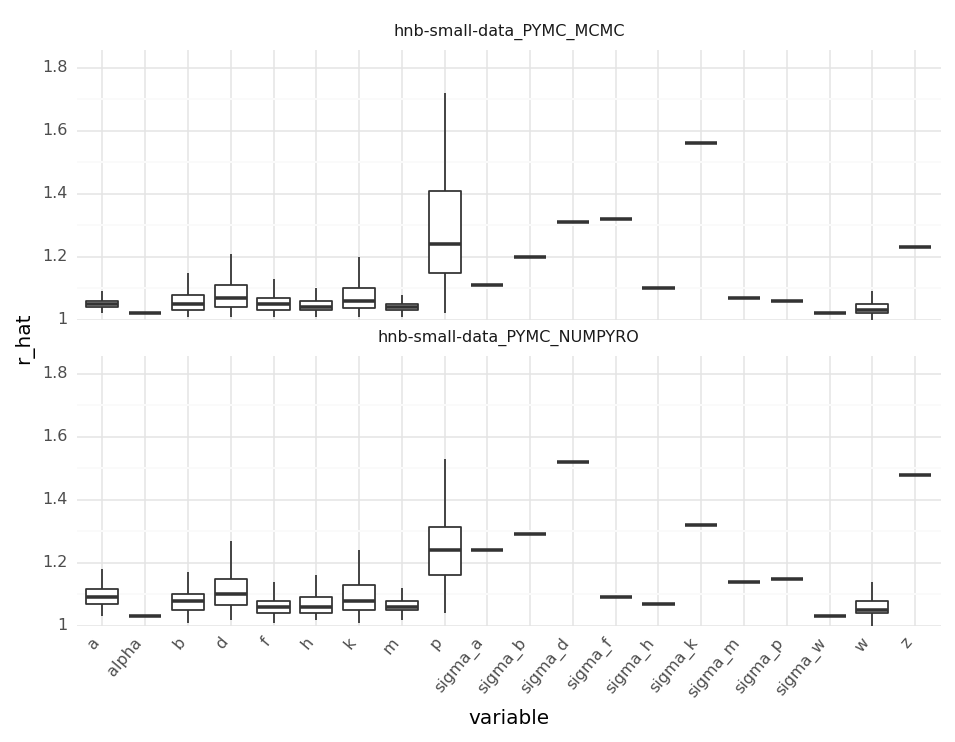

<ggplot: (338830484)>

In [11]:
(
    gg.ggplot(posterior_summaries, gg.aes(x="variable", y="r_hat"))
    + gg.facet_wrap("~model", ncol=1)
    + gg.geom_boxplot(outlier_alpha=0)
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0), limits=(1, None))
    + gg.theme(axis_text_x=gg.element_text(angle=50, hjust=1), figure_size=(5, 5))
)

In [12]:
ess_averages = (
    posterior_summaries.groupby(["model", "variable"])["ess_bulk"]
    .mean()
    .reset_index(drop=False)
    .round({"ess_bulk": 1})
    .pivot_wider(index="variable", names_from="model", values_from="ess_bulk")
)
ess_averages

variable  hnb-small-data_PYMC_MCMC  hnb-small-data_PYMC_NUMPYRO
0         a                     130.5                         66.3
1     alpha                     112.0                         97.0
2         b                      84.2                         56.1
3         d                      59.2                         37.1
4         f                      93.8                         65.6
5         h                      98.9                         60.5
6         k                      77.7                         47.5
7         m                     125.9                         70.2
8         p                      22.0                         18.0
9   sigma_a                      26.0                         13.0
10  sigma_b                      16.0                         11.0
11  sigma_d                      10.0                          7.0
12  sigma_f                      11.0                         36.0
13  sigma_h                      32.0                         45.0
14  sigma_k                       7.0                         10.0
15  sigma_m                      52.0                         21.0
16  sigma_p                      84.0                         19.0
17  sigma_w                     111.0                         71.0
18        w                     126.6                         70.9
19        z                      15.0                          8.0

### Analyze marginal posteriors

In [13]:
posterior_summaries.query("variable == 'z'")

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0             z  0.249  1.660    -2.326      3.433      0.441    0.318   
14191         z -0.812  1.869    -4.785      1.232      0.701    0.517   

       ess_bulk  ess_tail  r_hat variable                        model  
0          15.0      31.0   1.23        z     hnb-small-data_PYMC_MCMC  
14191       8.0      12.0   1.48        z  hnb-small-data_PYMC_NUMPYRO

In [14]:
def _extract_var_posterior(
    post_summ: pd.DataFrame, v: str, dim_names: list[str]
) -> pd.DataFrame:
    return (
        post_summ.copy()
        .query(f"variable == '{v}'")
        .reset_index(drop=True)
        .pipe(
            extract_coords_param_names,
            names=dim_names,
            col="parameter",
        )
    )


def _extract_w_posterior(post_summ: pd.DataFrame) -> pd.DataFrame:
    return _extract_var_posterior(
        post_summ, "w", ["hugo_symbol", "cancer_gene", "lineage"]
    )


def _extract_k_posterior(post_summ: pd.DataFrame) -> pd.DataFrame:
    return _extract_var_posterior(post_summ, "k", ["hugo_symbol", "lineage"])


def _extract_m_posterior(post_summ: pd.DataFrame) -> pd.DataFrame:
    return _extract_var_posterior(post_summ, "m", ["hugo_symbol", "lineage"])


def _extract_h_posterior(post_summ: pd.DataFrame) -> pd.DataFrame:
    return _extract_var_posterior(post_summ, "h", ["hugo_symbol", "lineage"])


def _extract_d_posterior(post_summ: pd.DataFrame) -> pd.DataFrame:
    return _extract_var_posterior(post_summ, "d", ["hugo_symbol", "lineage"])

In [15]:
w_post = _extract_w_posterior(posterior_summaries)

In [16]:
def _plot_lineage_specific_w_posterior(
    w_post: pd.DataFrame, cgc_genes: dict[str, set[str]]
) -> gg.ggplot:
    plot_df = (
        w_post.copy()
        .assign(
            lineage_spec=lambda d: [
                cg in cgc_genes[line] for cg, line in zip(d.cancer_gene, d.lineage)
            ]
        )
        .query("lineage_spec")
    )

    return (
        gg.ggplot(plot_df, gg.aes(x="cancer_gene", y="hugo_symbol", fill="mean"))
        + gg.facet_grid("model ~ lineage", scales="free_x")
        + gg.geom_tile(gg.aes(alpha="1/(sd**2)"))
        + gg.scale_alpha_continuous(range=(0, 1))
        + sgg.scale_fill_heatmap(midpoint=0)
        + gg.theme(
            axis_text=gg.element_text(size=7),
            axis_text_x=gg.element_text(angle=90),
            figure_size=(8, 17),
            panel_grid=gg.element_blank(),
        )
    )

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


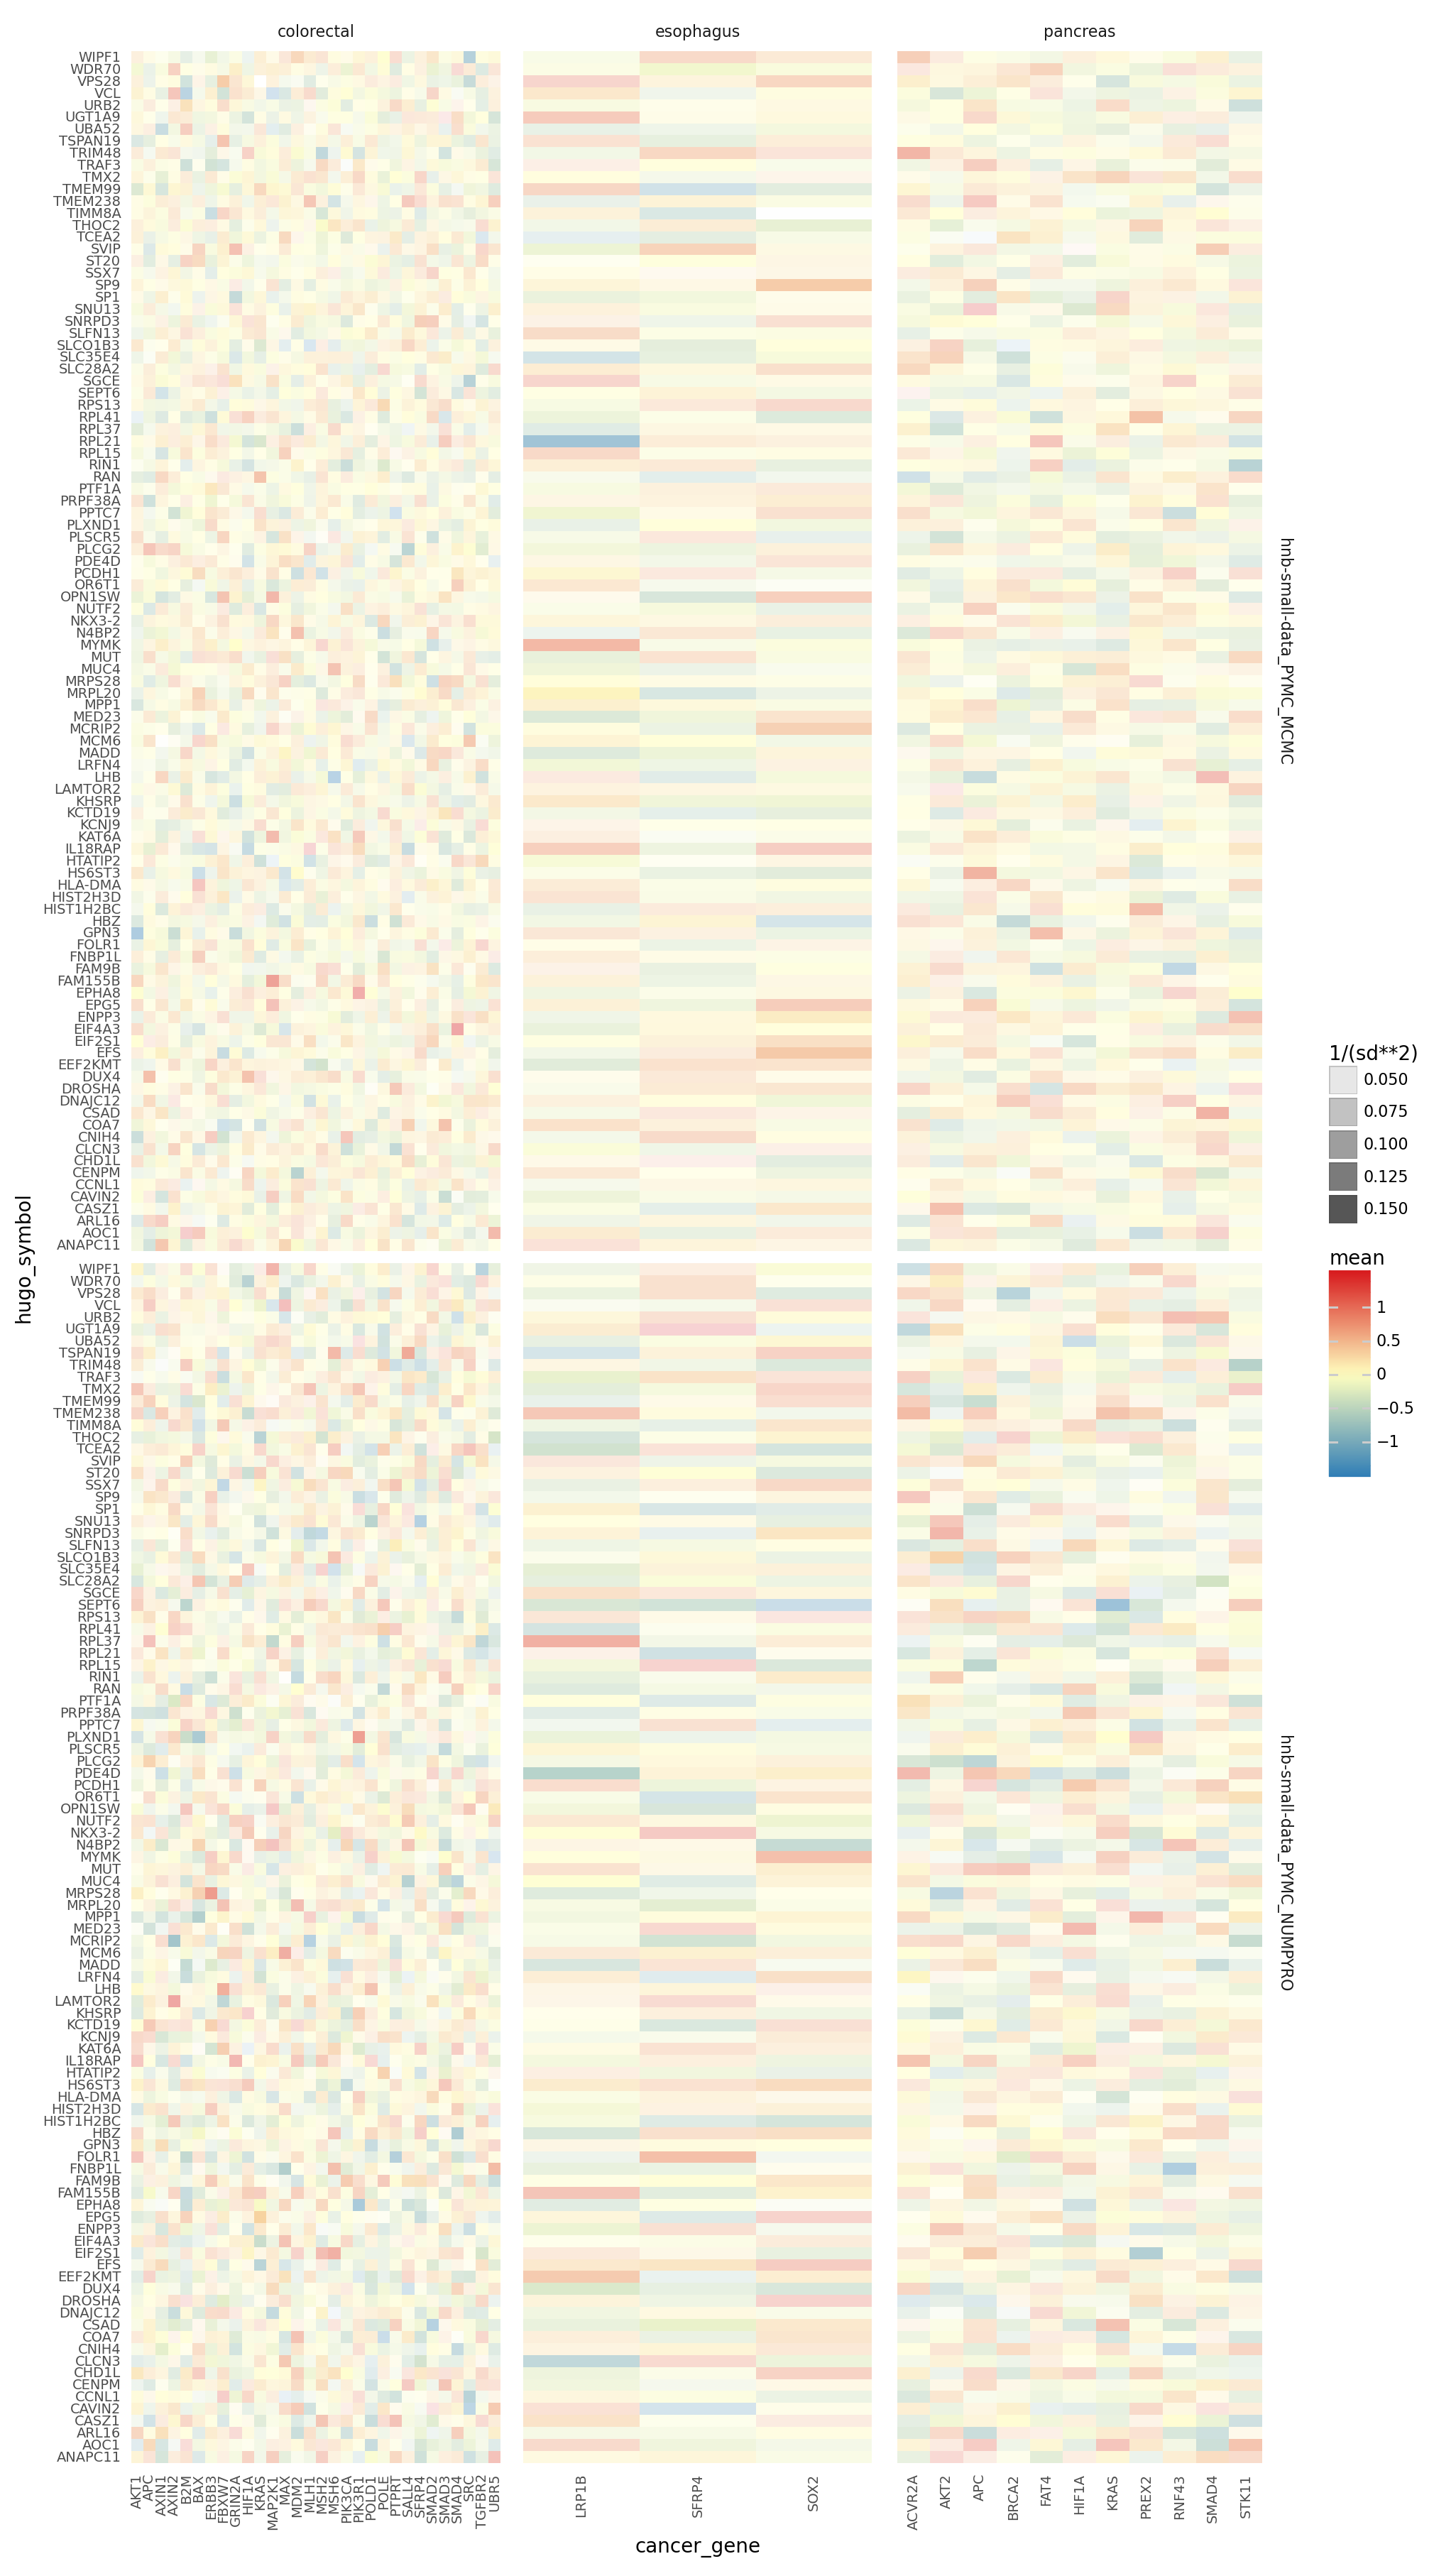

<ggplot: (339428398)>

In [17]:
_plot_lineage_specific_w_posterior(w_post, cgc_genes)

In [18]:
def _plot_w_post_comparing_models(
    w_post: pd.DataFrame, x_mdl: str, y_mdl: str
) -> gg.ggplot:
    plot_df = w_post.copy()[
        ["mean", "model", "hugo_symbol", "cancer_gene", "lineage"]
    ].pivot_wider(
        ["hugo_symbol", "cancer_gene", "lineage"],
        names_from="model",
        values_from="mean",
    )

    return (
        gg.ggplot(plot_df, gg.aes(x=x_mdl, y=y_mdl))
        + gg.geom_hline(yintercept=0, linetype="--")
        + gg.geom_vline(xintercept=0, linetype="--")
        + gg.geom_abline(slope=1, intercept=0, color="blue")
        + gg.geom_point(gg.aes(color="lineage"), alpha=0.2)
        + gg.scale_color_brewer(
            type="qual",
            palette="Set1",
            guide=gg.guide_legend(override_aes={"alpha": 1, "size": 2}),
        )
        + gg.coord_equal()
    )

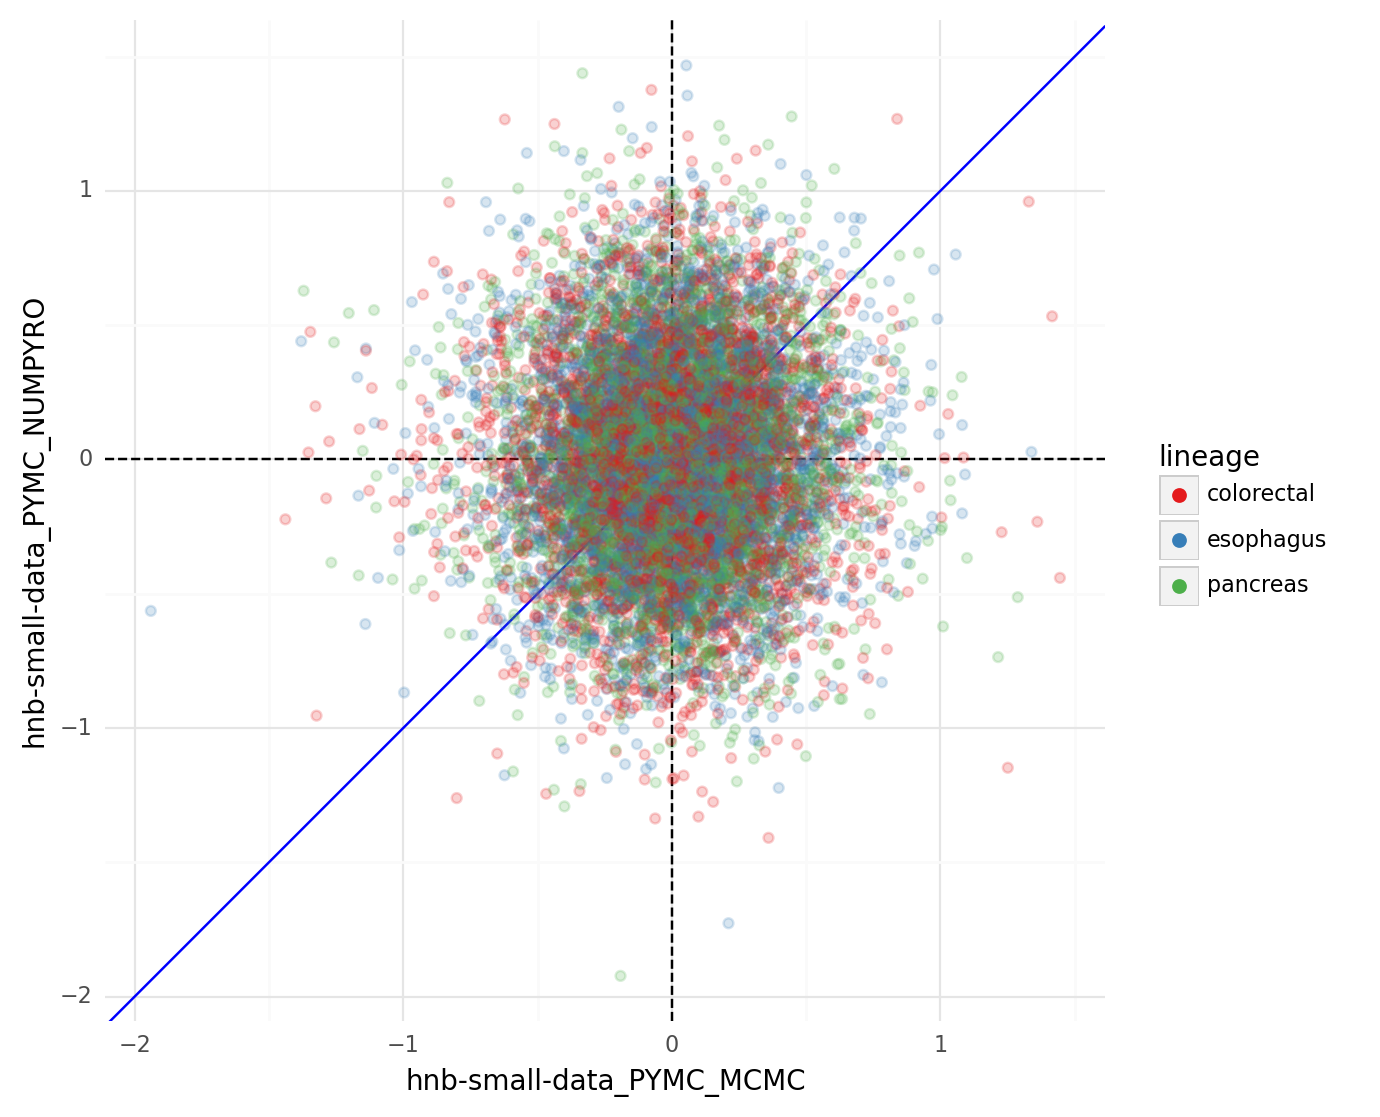

<ggplot: (341299954)>

In [19]:
_plot_w_post_comparing_models(
    w_post, "hnb-small-data_PYMC_MCMC", "hnb-small-data_PYMC_NUMPYRO"
)

In [20]:
posterior_summaries.filter_string("variable", "^sigma")

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
201     sigma_a  1.953  1.287     0.218      3.663      0.245    0.175   
202     sigma_b  0.069  0.006     0.061      0.078      0.001    0.001   
203     sigma_d  0.054  0.009     0.038      0.067      0.003    0.002   
204     sigma_f  0.024  0.004     0.017      0.031      0.001    0.001   
205     sigma_h  0.034  0.004     0.027      0.040      0.001    0.001   
206     sigma_k  0.044  0.006     0.034      0.053      0.002    0.002   
207     sigma_m  0.033  0.014     0.008      0.052      0.002    0.001   
208     sigma_w  2.804  1.656     0.371      4.795      0.148    0.105   
209     sigma_p  0.594  0.034     0.535      0.643      0.004    0.003   
14392   sigma_a  2.395  1.680     0.202      4.849      0.521    0.393   
14393   sigma_b  0.071  0.005     0.062      0.079      0.002    0.001   
14394   sigma_d  0.059  0.009     0.043      0.072      0.003    0.003   
14395   sigma_f  0.023  0.004     0.017      0.029      0.001    0.000   
14396   sigma_h  0.033  0.004     0.027      0.038      0.001    0.000   
14397   sigma_k  0.044  0.005     0.036      0.053      0.002    0.001   
14398   sigma_m  0.031  0.013     0.009      0.051      0.003    0.002   
14399   sigma_w  2.789  1.713     0.314      4.901      0.188    0.133   
14400   sigma_p  0.593  0.034     0.540      0.650      0.008    0.006   

       ess_bulk  ess_tail  r_hat variable                        model  
201        26.0      92.0   1.11  sigma_a     hnb-small-data_PYMC_MCMC  
202        16.0      53.0   1.20  sigma_b     hnb-small-data_PYMC_MCMC  
203        10.0      30.0   1.31  sigma_d     hnb-small-data_PYMC_MCMC  
204        11.0      35.0   1.32  sigma_f     hnb-small-data_PYMC_MCMC  
205        32.0     174.0   1.10  sigma_h     hnb-small-data_PYMC_MCMC  
206         7.0      29.0   1.56  sigma_k     hnb-small-data_PYMC_MCMC  
207        52.0      82.0   1.07  sigma_m     hnb-small-data_PYMC_MCMC  
208       111.0     183.0   1.02  sigma_w     hnb-small-data_PYMC_MCMC  
209        84.0     310.0   1.06  sigma_p     hnb-small-data_PYMC_MCMC  
14392      13.0      29.0   1.24  sigma_a  hnb-small-data_PYMC_NUMPYRO  
14393      11.0      21.0   1.29  sigma_b  hnb-small-data_PYMC_NUMPYRO  
14394       7.0      15.0   1.52  sigma_d  hnb-small-data_PYMC_NUMPYRO  
14395      36.0     133.0   1.09  sigma_f  hnb-small-data_PYMC_NUMPYRO  
14396      45.0      68.0   1.07  sigma_h  hnb-small-data_PYMC_NUMPYRO  
14397      10.0      28.0   1.32  sigma_k  hnb-small-data_PYMC_NUMPYRO  
14398      21.0      34.0   1.14  sigma_m  hnb-small-data_PYMC_NUMPYRO  
14399      71.0     139.0   1.03  sigma_w  hnb-small-data_PYMC_NUMPYRO  
14400      19.0      23.0   1.15  sigma_p  hnb-small-data_PYMC_NUMPYRO

## Model: "hnb-small-data_v2"

### Compute metrics

| Backend | Job ID   | Duration | CPU efficiency (%) | Resources               | Max mem. used |
|---------|----------|----------|--------------------|-------------------------|---------------|
| PyMC    | 53592797 | 18:34:51 | 99.90              | cpu=1,mem=15.62G,node=1 | 4.98G         |
| PyMC    | 53592800 | 19:33:16 | 99.86              | cpu=1,mem=15.62G,node=1 | 3.32G         |
| PyMC    | 53592801 | 18:35:20 | 99.91              | cpu=1,mem=15.62G,node=1 | 5.02G         |
| PyMC    | 53592804 | 18:20:46 | 99.89              | cpu=1,mem=15.62G,node=1 | 3.33G         |
| Numpyro | 53592798 | 09:39:03 | 99.90              | cpu=1,mem=27.34G,node=1 | 3.50G         |
| Numpyro | 53592799 | 09:28:58 | 99.92              | cpu=1,mem=27.34G,node=1 | 7.97G         |
| Numpyro | 53592802 | 09:49:36 | 99.87              | cpu=1,mem=27.34G,node=1 | 2.87G         |
| Numpyro | 53592803 | 10:24:01 | 99.92              | cpu=1,mem=27.34G,node=1 | 7.59G         |

In [21]:
pymc_mcmc_pm_v2 = PosteriorSummaryManager("hnb-small-data_v2_PYMC_MCMC", models_dir())
pyro_mcmc_pm_v2 = PosteriorSummaryManager(
    "hnb-small-data_v2_PYMC_NUMPYRO", models_dir()
)

posterior_summaries_v2 = _prepare_posterior_summaries(
    [pymc_mcmc_pm_v2, pyro_mcmc_pm_v2]
)

### Analyze sampling process

In [22]:
for post_man in [pymc_mcmc_pm_v2, pyro_mcmc_pm_v2]:
    print(post_man.read_description())
    print("\n" + "=" * 80 + "\n" + "=" * 80 + "\n")

name: 'hnb-small-data_v2'
fit method: 'PYMC_MCMC'

--------------------------------------------------------------------------------

CONFIGURATION

{
    "name": "hnb-small-data_v2",
    "description": " Fit the model with a relatively small amount of data for testing purposes. Changes from v1: - only use Broad data and remove the screen batch effect `p` - reduce the width of the prior for `z` - replace priors on `sigma_*` with `HalfNormal(0, 1)` - reduce target_accept to 0.98 to help with searching of posterior space - update O2 resources based on past performance ",
    "active": true,
    "model": "HIERARCHICAL_NB",
    "data_file": "DEPMAP_CRC_PANC_ESO_SUBSAMPLE",
    "sampling_kwargs": {
        "pymc_mcmc": {
            "draws": 1000,
            "init": "adapt_diag",
            "n_init": 200000,
            "chains": null,
            "cores": null,
            "tune": 1000,
            "progressbar": true,
            "target_accept": 0.98
        },
        "pymc_advi": null

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


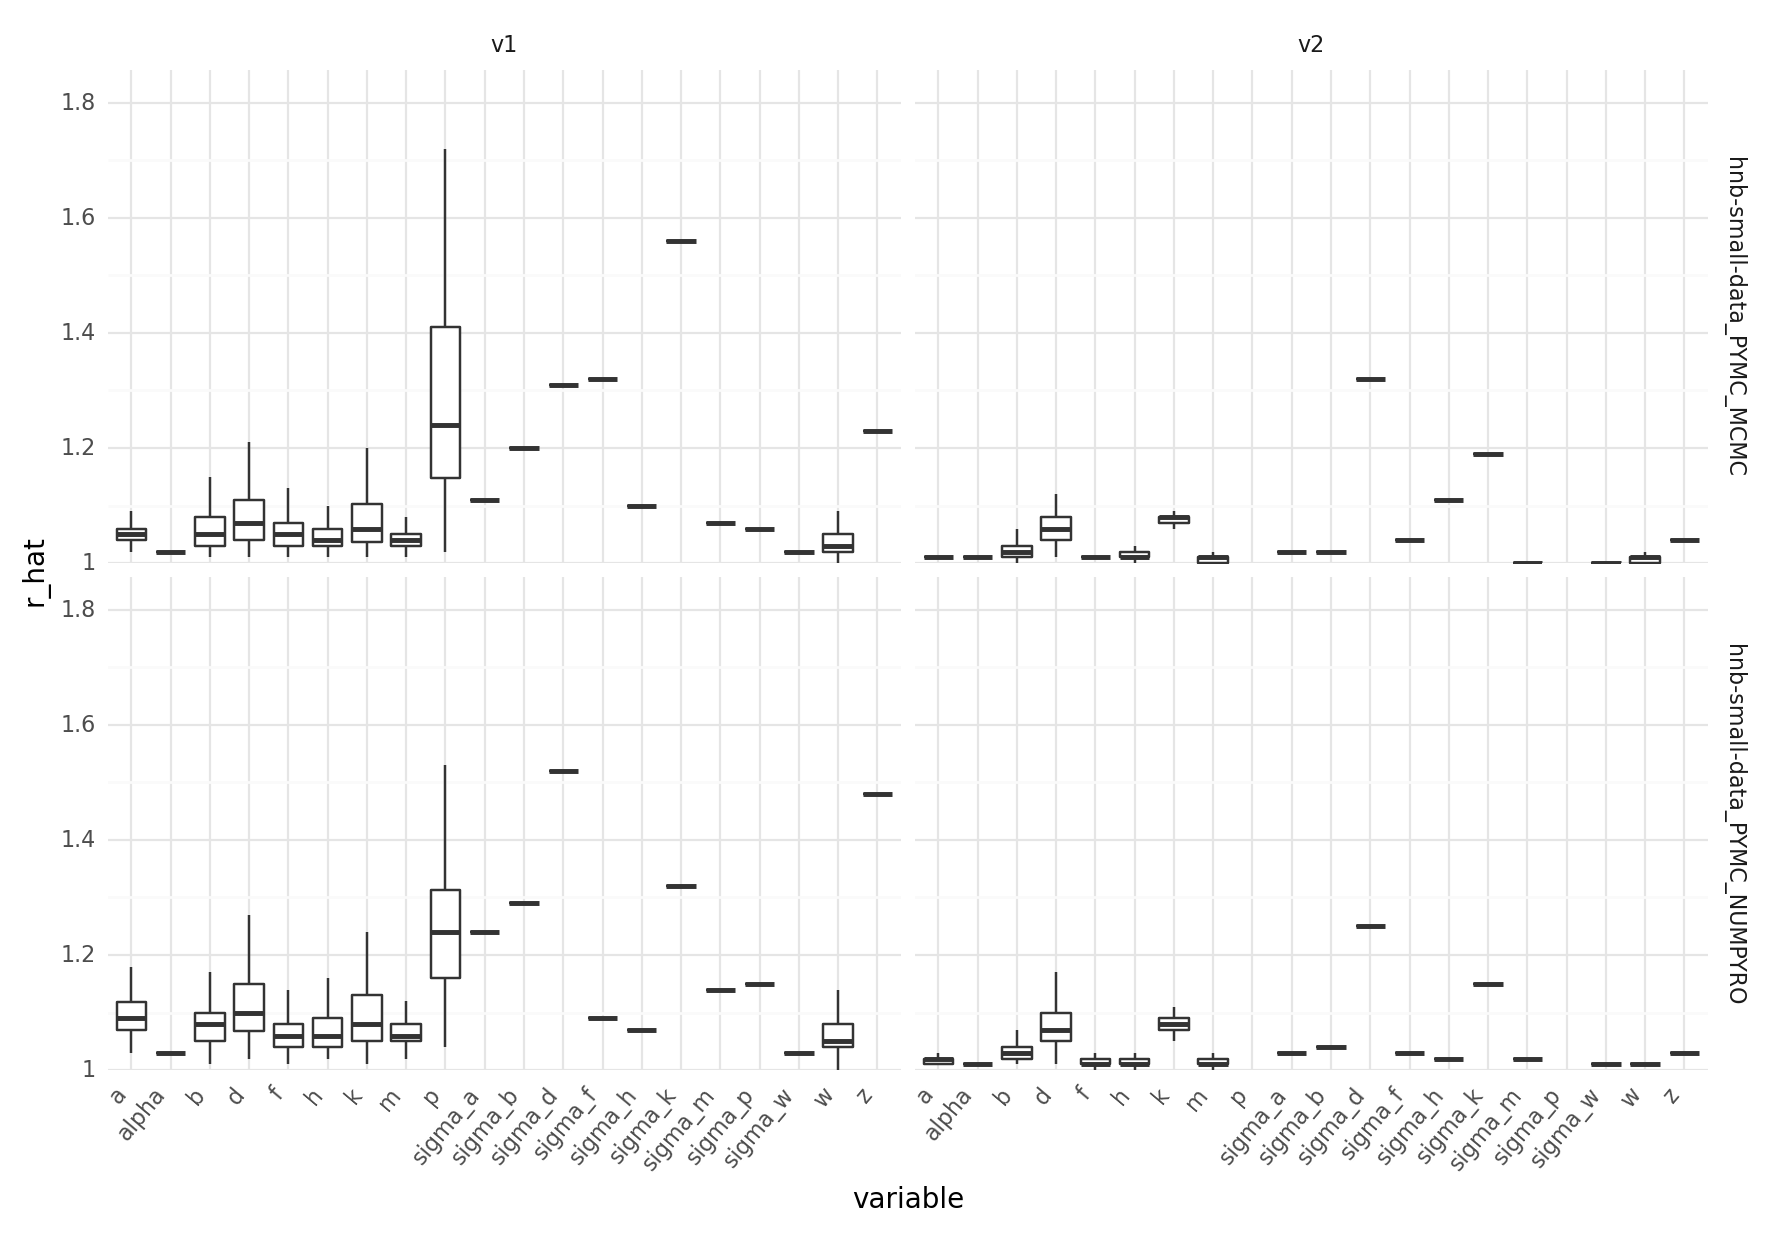

<ggplot: (341738208)>

In [23]:
plt_df = (
    pd.concat(
        [
            p.assign(ver=f"v{i+1}")
            for i, p in enumerate([posterior_summaries, posterior_summaries_v2])
        ]
    )
    .reset_index(drop=True)
    .assign(model=lambda d: [m.replace("_v2", "") for m in d.model])
)

(
    gg.ggplot(plt_df, gg.aes(x="variable", y="r_hat"))
    + gg.facet_grid("model~ver")
    + gg.geom_boxplot(outlier_alpha=0)
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0), limits=(1, None))
    + gg.theme(axis_text_x=gg.element_text(angle=50, hjust=1), figure_size=(8, 5))
)

In [24]:
posterior_summaries_v2.groupby(["model", "variable"])["ess_bulk"].describe()

count        mean         std  \
model                          variable                                    
hnb-small-data_v2_PYMC_MCMC    a           386.0  592.217617  100.107445   
                               alpha         1.0  516.000000         NaN   
                               b           103.0  267.805825   93.695696   
                               d           300.0   84.263333   53.498607   
                               f           103.0  466.912621  116.327134   
                               h           300.0  467.620000  106.845381   
                               k           300.0  392.890000  159.714664   
                               m           300.0  584.473333   99.601158   
                               sigma_a       1.0  268.000000         NaN   
                               sigma_b       1.0  143.000000         NaN   
                               sigma_d       1.0   10.000000         NaN   
                               sigma_f       1.0   79.000000         NaN   
                               sigma_h       1.0   29.000000         NaN   
                               sigma_k       1.0   15.000000         NaN   
                               sigma_m       1.0  490.000000         NaN   
                               sigma_w       1.0  575.000000         NaN   
                               w         11700.0  586.355812   98.437952   
                               z             1.0  185.000000         NaN   
hnb-small-data_v2_PYMC_NUMPYRO a           386.0  356.500000   60.515845   
                               alpha         1.0  332.000000         NaN   
                               b           103.0  156.650485   57.879474   
                               d           300.0   61.946667   39.850773   
                               f           103.0  296.155340   63.442078   
                               h           300.0  303.500000   57.741640   
                               k           300.0  262.413333   83.149596   
                               m           300.0  346.726667   59.244112   
                               sigma_a       1.0  220.000000         NaN   
                               sigma_b       1.0   77.000000         NaN   
                               sigma_d       1.0   12.000000         NaN   
                               sigma_f       1.0  139.000000         NaN   
                               sigma_h       1.0  121.000000         NaN   
                               sigma_k       1.0   20.000000         NaN   
                               sigma_m       1.0  202.000000         NaN   
                               sigma_w       1.0  412.000000         NaN   
                               w         11700.0  357.748803   59.108414   
                               z             1.0  137.000000         NaN   

                                           min     25%    50%     75%    max  
model                          variable                                       
hnb-small-data_v2_PYMC_MCMC    a         189.0  530.00  592.0  666.00  878.0  
                               alpha     516.0  516.00  516.0  516.00  516.0  
                               b          81.0  203.50  270.0  316.50  538.0  
                               d          24.0   43.00   65.0  116.00  275.0  
                               f         100.0  391.00  466.0  536.00  791.0  
                               h          36.0  410.00  474.0  536.00  715.0  
                               k          59.0  279.75  388.5  518.00  769.0  
                               m         296.0  515.00  583.0  641.75  896.0  
                               sigma_a   268.0  268.00  268.0  268.00  268.0  
                               sigma_b   143.0  143.00  143.0  143.00  143.0  
                               sigma_d    10.0   10.00   10.0   10.00   10.0  
                               sigma_f    79.0   79.00   79.0   79.00   79.0  
                               sigma_h    29.0  

### Analyze marginal posteriors

In [25]:
w_post_v2 = _extract_w_posterior(posterior_summaries_v2)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


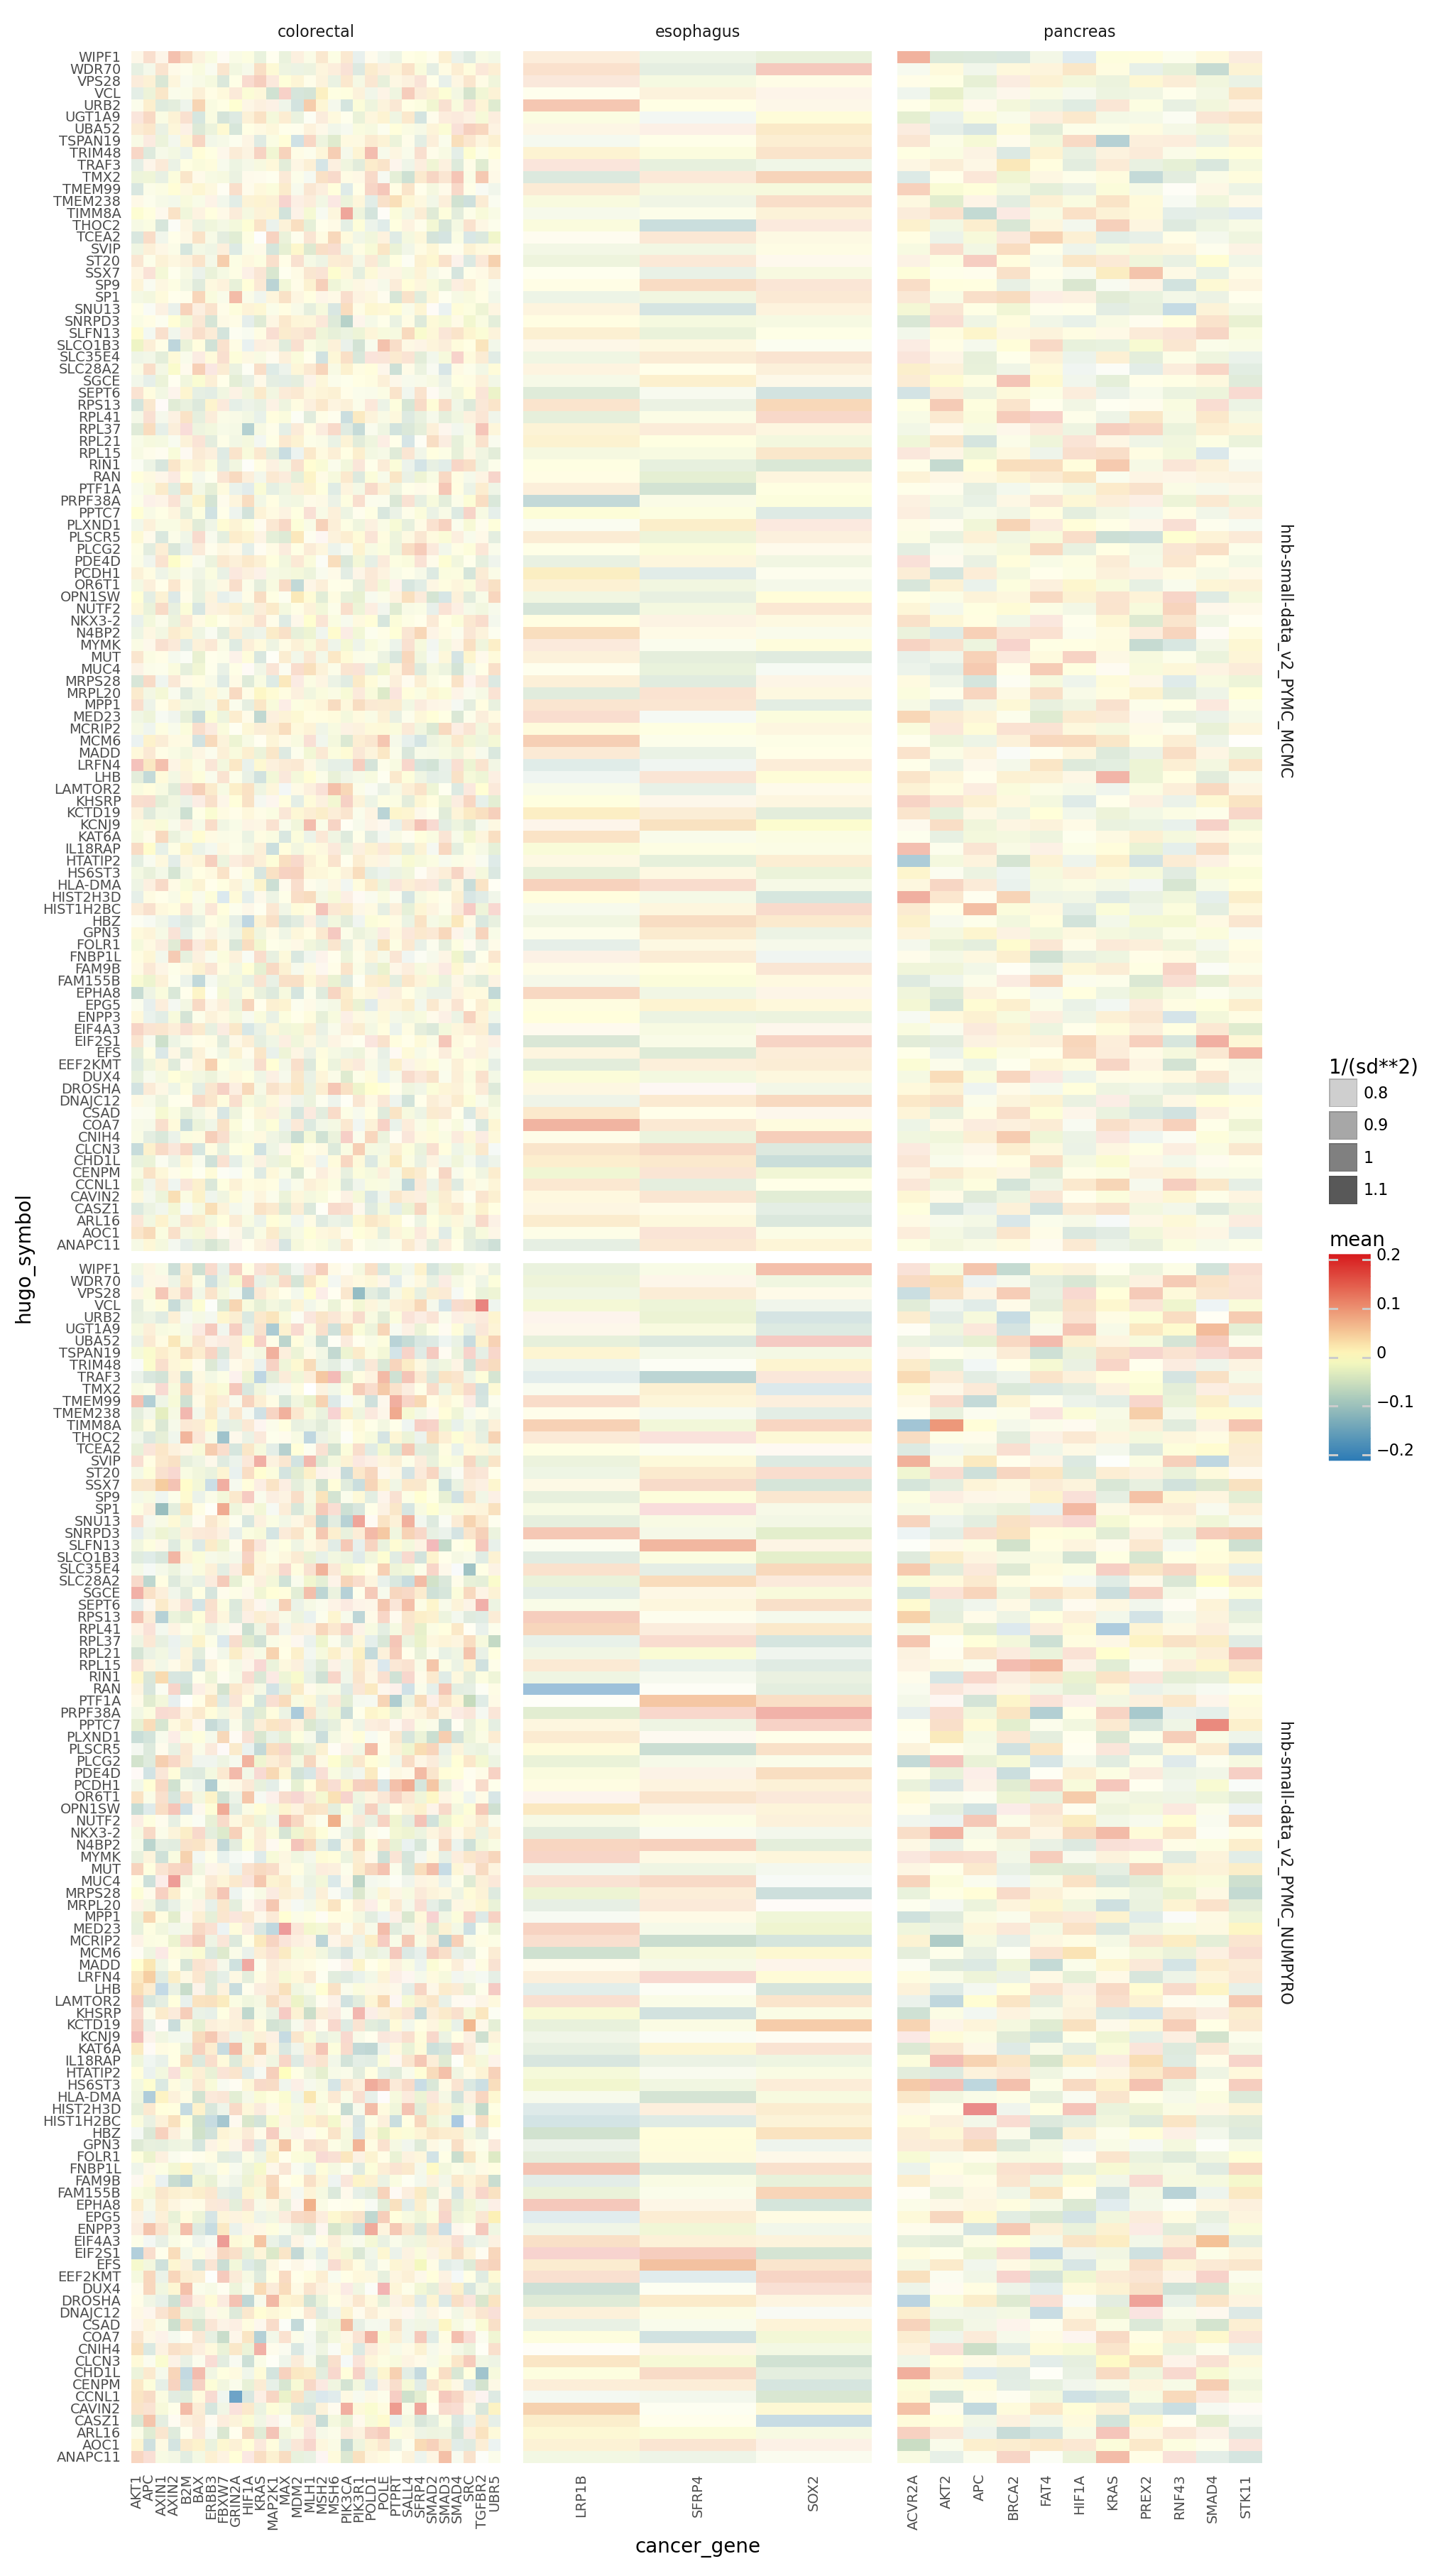

<ggplot: (342458155)>

In [26]:
_plot_lineage_specific_w_posterior(w_post_v2, cgc_genes)

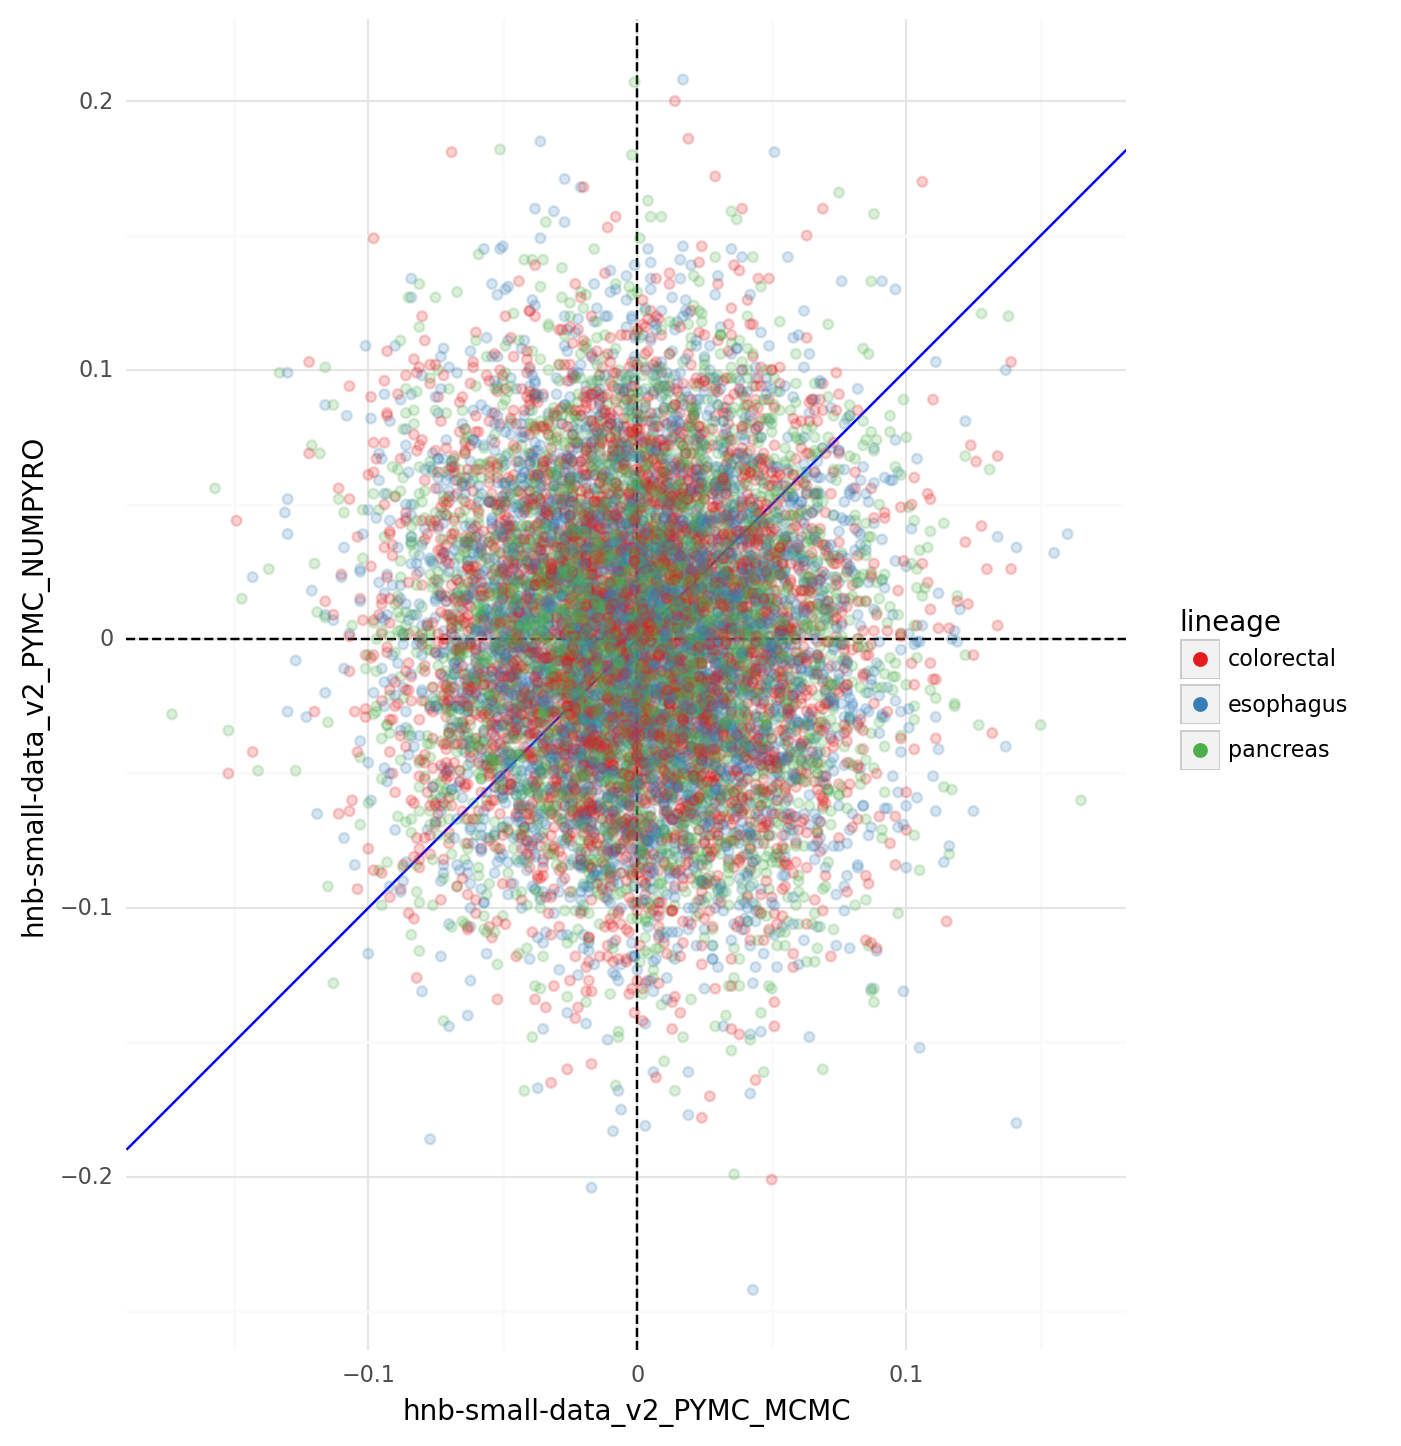

<ggplot: (338758341)>

In [27]:
_plot_w_post_comparing_models(
    w_post_v2, "hnb-small-data_v2_PYMC_MCMC", "hnb-small-data_v2_PYMC_NUMPYRO"
)

In [28]:
w_post.query("`hdi_94.5%` < 0 or `hdi_5.5%` > 0")

Empty DataFrame
Columns: [parameter, mean, sd, hdi_5.5%, hdi_94.5%, mcse_mean, mcse_sd, ess_bulk, ess_tail, r_hat, variable, model, hugo_symbol, cancer_gene, lineage]
Index: []

In [29]:
lineage_cell_line_map = (
    crispr_data.copy()[["depmap_id", "lineage"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


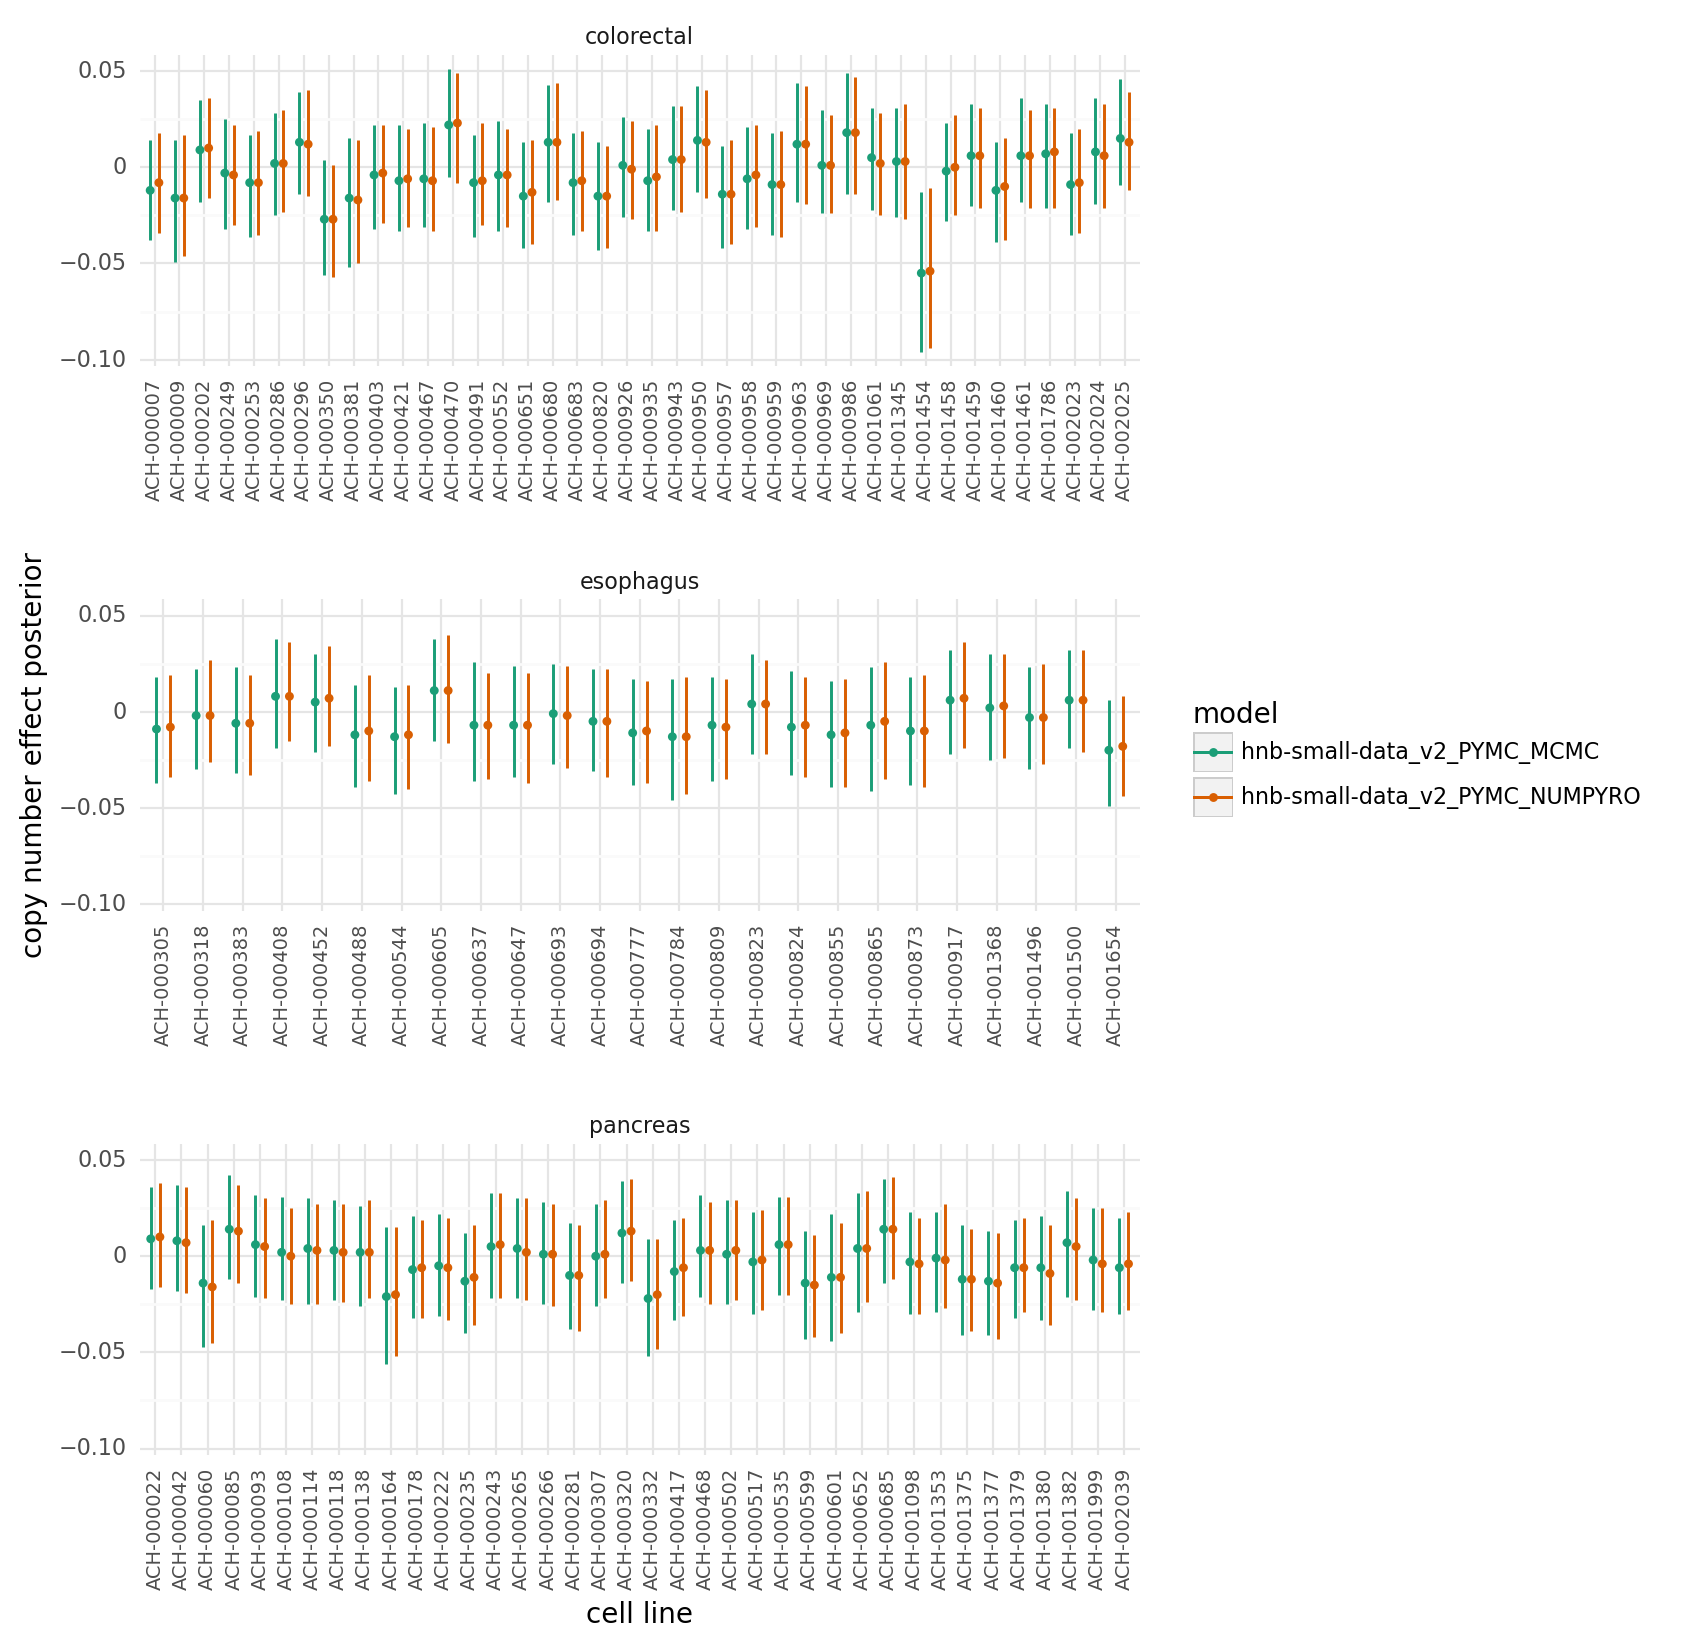

<ggplot: (339479733)>

In [30]:
f_post_v2 = (
    posterior_summaries_v2.copy()
    .query("variable == 'f'")
    .pipe(extract_coords_param_names, names=["depmap_id"], col="parameter")
    .merge(lineage_cell_line_map, on="depmap_id")
    .sort_values(["lineage", "depmap_id"])
    .assign(
        depmap_id=lambda d: pd.Categorical(
            d.depmap_id, categories=d.depmap_id.unique(), ordered=True
        )
    )
)

pos = gg.position_dodge(width=0.7)

(
    gg.ggplot(f_post_v2, gg.aes(x="depmap_id", y="mean", color="model"))
    + gg.facet_wrap("~lineage", scales="free_x", ncol=1)
    + gg.geom_linerange(
        gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), position=pos, size=0.6
    )
    + gg.geom_point(position=pos, size=0.8)
    + gg.scale_color_brewer(type="qual", palette="Dark2")
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, size=7),
        figure_size=(5, 7),
        subplots_adjust={"hspace": 0.75},
    )
    + gg.labs(x="cell line", y="copy number effect posterior", color="model")
)

In [31]:
k_post_v2 = _extract_k_posterior(posterior_summaries_v2)
k_post_v2.sort_values("mean").pipe(head_tail, n=3)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
193       k[RAN, esophagus] -0.009  0.025    -0.042      0.019      0.004   
493       k[RAN, esophagus] -0.008  0.021    -0.040      0.021      0.002   
199     k[RPL15, esophagus] -0.007  0.022    -0.037      0.020      0.003   
516     k[SGCE, colorectal]  0.006  0.016    -0.015      0.036      0.001   
336  k[DNAJC12, colorectal]  0.006  0.017    -0.017      0.031      0.002   
12    k[CAVIN2, colorectal]  0.008  0.020    -0.018      0.037      0.004   

     mcse_sd  ess_bulk  ess_tail  r_hat variable  \
193    0.003      72.0      64.0   1.08        k   
493    0.002     186.0     113.0   1.08        k   
199    0.003     133.0      43.0   1.07        k   
516    0.001     291.0     242.0   1.07        k   
336    0.002     158.0     107.0   1.08        k   
12     0.003      59.0      40.0   1.08        k   

                              model hugo_symbol     lineage  
193     hnb-small-data_v2_PYMC_MCMC         RAN   esophagus  
493  hnb-small-data_v2_PYMC_NUMPYRO         RAN   esophagus  
199     hnb-small-data_v2_PYMC_MCMC       RPL15   esophagus  
516  hnb-small-data_v2_PYMC_NUMPYRO        SGCE  colorectal  
336  hnb-small-data_v2_PYMC_NUMPYRO     DNAJC12  colorectal  
12      hnb-small-data_v2_PYMC_MCMC      CAVIN2  colorectal

In [32]:
def _plot_lineage_by_gene_heatmap(df: pd.DataFrame) -> gg.ggplot:
    return (
        gg.ggplot(df, gg.aes(x="hugo_symbol", y="lineage"))
        + gg.geom_tile(gg.aes(fill="mean"))
        + gg.scale_x_discrete(expand=(0, 0.5))
        + gg.scale_y_discrete(expand=(0, 0.5))
        + sgg.scale_fill_heatmap()
        + gg.theme(
            axis_text_x=gg.element_text(angle=90, size=6),
            panel_grid=gg.element_blank(),
            figure_size=(8, 0.6),
        )
    )

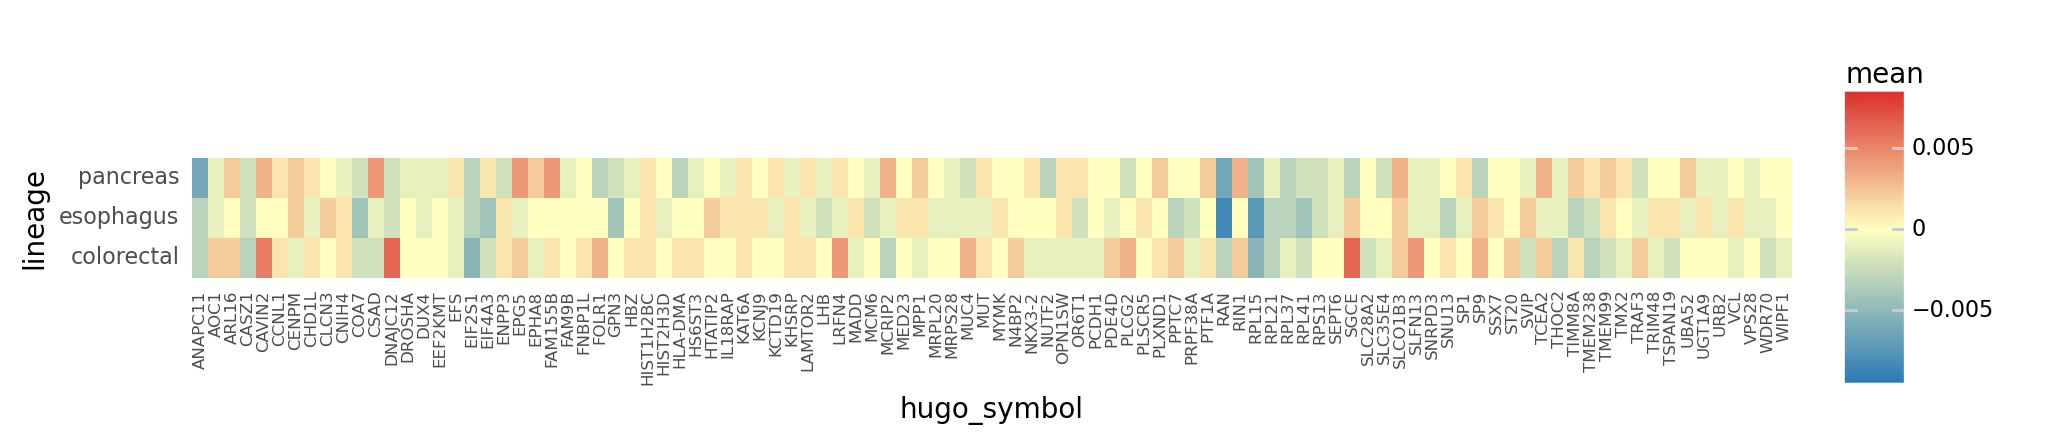

<ggplot: (340914609)>

In [33]:
_plot_lineage_by_gene_heatmap(k_post_v2)

In [34]:
m_post_v2 = _extract_m_posterior(
    posterior_summaries_v2,
)
m_post_v2.sort_values("mean").pipe(head_tail, n=3)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
267    m[TMX2, colorectal] -0.007  0.026    -0.047      0.027      0.001   
433    m[MED23, esophagus] -0.006  0.025    -0.040      0.031      0.001   
438  m[MRPL20, colorectal] -0.005  0.024    -0.044      0.025      0.001   
444    m[MUC4, colorectal]  0.006  0.024    -0.030      0.046      0.002   
309   m[CASZ1, colorectal]  0.006  0.022    -0.024      0.044      0.001   
9     m[CASZ1, colorectal]  0.007  0.024    -0.029      0.043      0.001   

     mcse_sd  ess_bulk  ess_tail  r_hat variable  \
267    0.001     723.0    1055.0   1.00        m   
433    0.001     296.0     456.0   1.01        m   
438    0.001     465.0     866.0   1.02        m   
444    0.001     240.0     660.0   1.01        m   
309    0.001     334.0     626.0   1.01        m   
9      0.001     722.0    1210.0   1.01        m   

                              model hugo_symbol     lineage  
267     hnb-small-data_v2_PYMC_MCMC        TMX2  colorectal  
433  hnb-small-data_v2_PYMC_NUMPYRO       MED23   esophagus  
438  hnb-small-data_v2_PYMC_NUMPYRO      MRPL20  colorectal  
444  hnb-small-data_v2_PYMC_NUMPYRO        MUC4  colorectal  
309  hnb-small-data_v2_PYMC_NUMPYRO       CASZ1  colorectal  
9       hnb-small-data_v2_PYMC_MCMC       CASZ1  colorectal

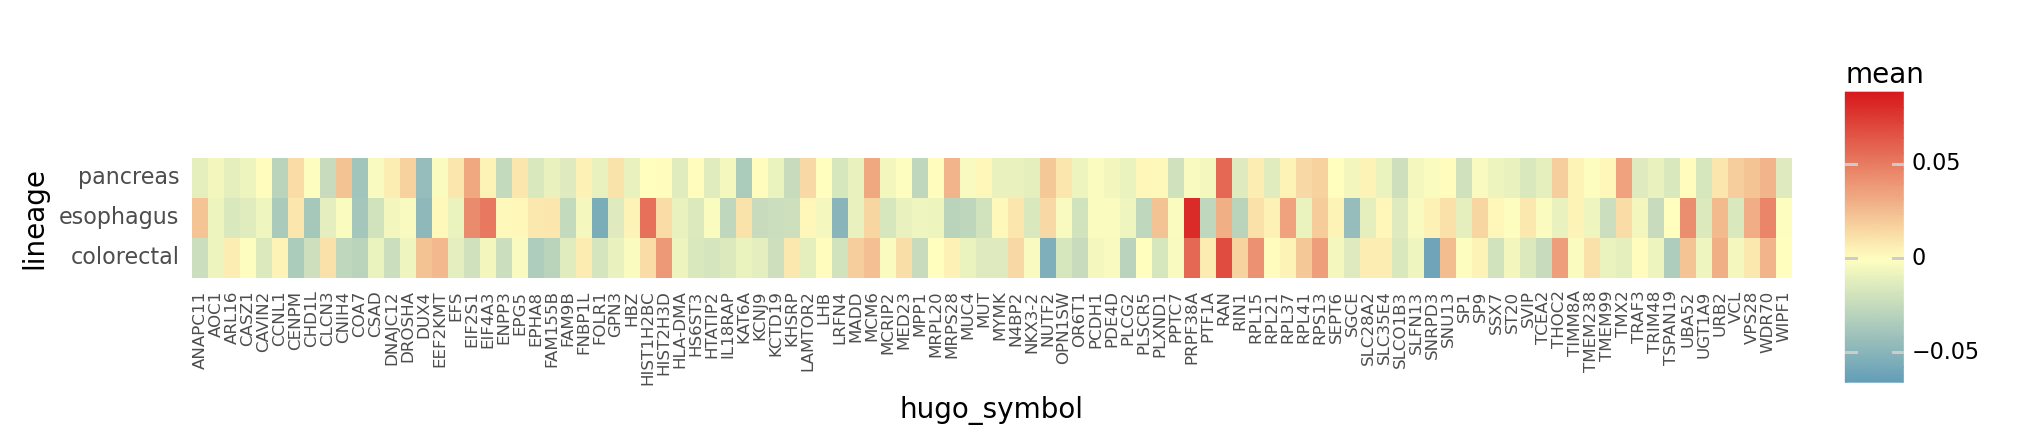

<ggplot: (339920749)>

In [35]:
h_post_v2 = _extract_h_posterior(posterior_summaries)
_plot_lineage_by_gene_heatmap(h_post_v2)

In [36]:
h_post_v2.sort_values(["mean"]).pipe(head_tail, n=3)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
231  h[SNRPD3, colorectal] -0.062  0.028    -0.108     -0.019      0.004   
531  h[SNRPD3, colorectal] -0.057  0.026    -0.097     -0.014      0.003   
76     h[FOLR1, esophagus] -0.056  0.028    -0.099     -0.009      0.003   
492     h[RAN, colorectal]  0.065  0.027     0.023      0.106      0.003   
487  h[PRPF38A, esophagus]  0.077  0.023     0.038      0.115      0.003   
187  h[PRPF38A, esophagus]  0.084  0.026     0.042      0.127      0.004   

     mcse_sd  ess_bulk  ess_tail  r_hat variable                        model  \
231    0.003      64.0     193.0   1.07        h     hnb-small-data_PYMC_MCMC   
531    0.002      78.0     136.0   1.05        h  hnb-small-data_PYMC_NUMPYRO   
76     0.002      76.0     288.0   1.05        h     hnb-small-data_PYMC_MCMC   
492    0.002      83.0     147.0   1.02        h  hnb-small-data_PYMC_NUMPYRO   
487    0.002      54.0     118.0   1.09        h  hnb-small-data_PYMC_NUMPYRO   
187    0.003      39.0      86.0   1.09        h     hnb-small-data_PYMC_MCMC   

    hugo_symbol     lineage  
231      SNRPD3  colorectal  
531      SNRPD3  colorectal  
76        FOLR1   esophagus  
492         RAN  colorectal  
487     PRPF38A   esophagus  
187     PRPF38A   esophagus

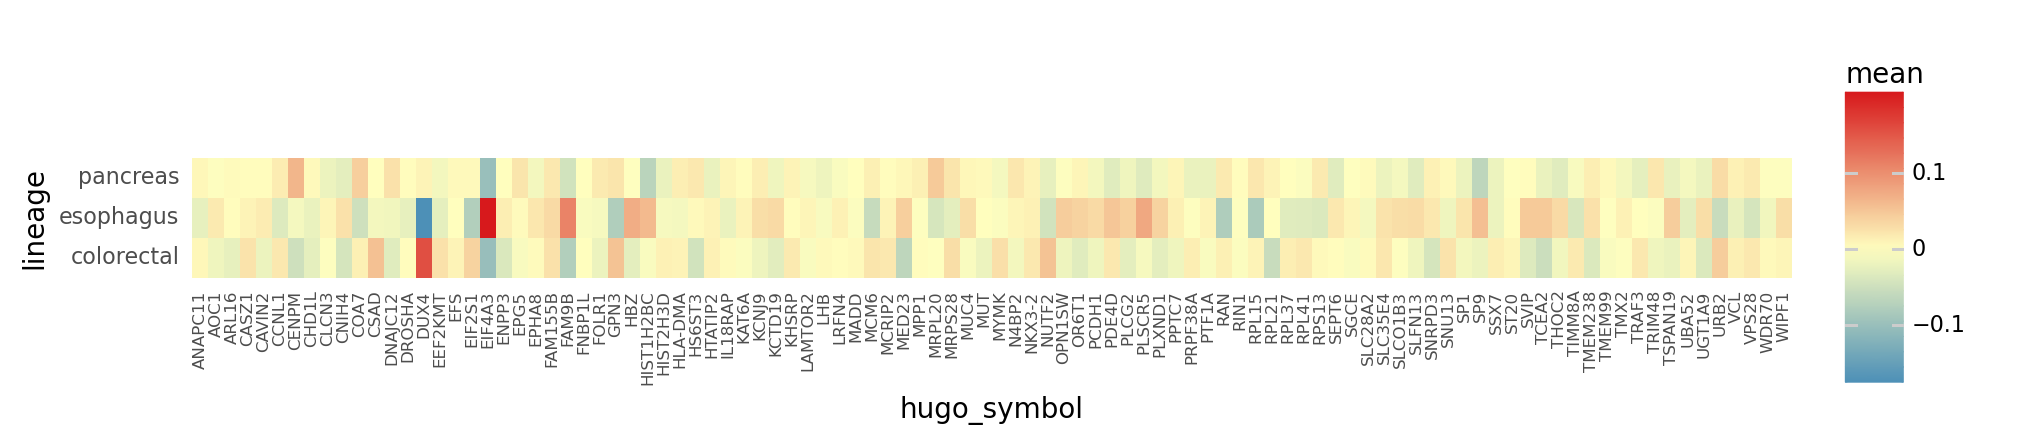

<ggplot: (341441449)>

In [37]:
d_post_v2 = _extract_d_posterior(posterior_summaries)
_plot_lineage_by_gene_heatmap(d_post_v2)

In [38]:
d_post_v2.sort_values(["mean"]).pipe(head_tail, n=5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
343     d[DUX4, esophagus] -0.166  0.059    -0.253     -0.074      0.013   
43      d[DUX4, esophagus] -0.163  0.056    -0.248     -0.073      0.012   
56     d[EIF4A3, pancreas] -0.108  0.057    -0.201     -0.018      0.017   
54   d[EIF4A3, colorectal] -0.100  0.057    -0.197     -0.017      0.014   
354  d[EIF4A3, colorectal] -0.096  0.060    -0.188      0.004      0.014   
70     d[FAM9B, esophagus]  0.107  0.044     0.041      0.184      0.006   
42     d[DUX4, colorectal]  0.138  0.053     0.059      0.223      0.011   
342    d[DUX4, colorectal]  0.150  0.051     0.074      0.229      0.011   
55    d[EIF4A3, esophagus]  0.168  0.073     0.064      0.292      0.022   
355   d[EIF4A3, esophagus]  0.197  0.071     0.074      0.294      0.024   

     mcse_sd  ess_bulk  ess_tail  r_hat variable                        model  \
343    0.009      22.0      72.0   1.14        d  hnb-small-data_PYMC_NUMPYRO   
43     0.009      21.0     145.0   1.14        d     hnb-small-data_PYMC_MCMC   
56     0.014      13.0      17.0   1.24        d     hnb-small-data_PYMC_MCMC   
54     0.011      18.0     101.0   1.16        d     hnb-small-data_PYMC_MCMC   
354    0.011      18.0      18.0   1.16        d  hnb-small-data_PYMC_NUMPYRO   
70     0.004      51.0     281.0   1.06        d     hnb-small-data_PYMC_MCMC   
42     0.008      24.0     108.0   1.14        d     hnb-small-data_PYMC_MCMC   
342    0.008      21.0      65.0   1.14        d  hnb-small-data_PYMC_NUMPYRO   
55     0.016      11.0      30.0   1.29        d     hnb-small-data_PYMC_MCMC   
355    0.018      10.0      15.0   1.31        d  hnb-small-data_PYMC_NUMPYRO   

    hugo_symbol     lineage  
343        DUX4   esophagus  
43         DUX4   esophagus  
56       EIF4A3    pancreas  
54       EIF4A3  colorectal  
354      EIF4A3  colorectal  
70        FAM9B   esophagus  
42         DUX4  colorectal  
342        DUX4  colorectal  
55       EIF4A3   esophagus  
355      EIF4A3   esophagus

In [39]:
posterior_summaries_v2.filter_string("variable", "^sigma")

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
1       sigma_a  0.719  0.552     0.002      1.450      0.029    0.020   
2       sigma_b  0.071  0.006     0.062      0.080      0.000    0.000   
3       sigma_d  0.403  0.017     0.378      0.429      0.005    0.004   
4       sigma_f  0.020  0.006     0.012      0.030      0.001    0.000   
5       sigma_h  0.022  0.006     0.013      0.032      0.001    0.001   
6       sigma_k  0.014  0.012     0.000      0.031      0.003    0.002   
7       sigma_m  0.020  0.014     0.000      0.038      0.001    0.000   
8       sigma_w  0.853  0.605     0.009      1.657      0.021    0.015   
13503   sigma_a  0.793  0.591     0.001      1.566      0.036    0.025   
13504   sigma_b  0.071  0.006     0.061      0.080      0.001    0.000   
13505   sigma_d  0.412  0.013     0.392      0.433      0.004    0.003   
13506   sigma_f  0.020  0.005     0.012      0.029      0.000    0.000   
13507   sigma_h  0.022  0.006     0.013      0.031      0.001    0.000   
13508   sigma_k  0.013  0.011     0.000      0.028      0.002    0.002   
13509   sigma_m  0.020  0.014     0.000      0.039      0.001    0.001   
13510   sigma_w  0.851  0.603     0.003      1.645      0.026    0.018   

       ess_bulk  ess_tail  r_hat variable                           model  
1         268.0     297.0   1.02  sigma_a     hnb-small-data_v2_PYMC_MCMC  
2         143.0     268.0   1.02  sigma_b     hnb-small-data_v2_PYMC_MCMC  
3          10.0      38.0   1.32  sigma_d     hnb-small-data_v2_PYMC_MCMC  
4          79.0     118.0   1.04  sigma_f     hnb-small-data_v2_PYMC_MCMC  
5          29.0      27.0   1.11  sigma_h     hnb-small-data_v2_PYMC_MCMC  
6          15.0      21.0   1.19  sigma_k     hnb-small-data_v2_PYMC_MCMC  
7         490.0     628.0   1.00  sigma_m     hnb-small-data_v2_PYMC_MCMC  
8         575.0     430.0   1.00  sigma_w     hnb-small-data_v2_PYMC_MCMC  
13503     220.0     290.0   1.03  sigma_a  hnb-small-data_v2_PYMC_NUMPYRO  
13504      77.0     151.0   1.04  sigma_b  hnb-small-data_v2_PYMC_NUMPYRO  
13505      12.0      42.0   1.25  sigma_d  hnb-small-data_v2_PYMC_NUMPYRO  
13506     139.0     215.0   1.03  sigma_f  hnb-small-data_v2_PYMC_NUMPYRO  
13507     121.0     221.0   1.02  sigma_h  hnb-small-data_v2_PYMC_NUMPYRO  
13508      20.0      53.0   1.15  sigma_k  hnb-small-data_v2_PYMC_NUMPYRO  
13509     202.0     200.0   1.02  sigma_m  hnb-small-data_v2_PYMC_NUMPYRO  
13510     412.0     462.0   1.01  sigma_w  hnb-small-data_v2_PYMC_NUMPYRO

### Conclusions and changes

- Increase the widths of the priors on $\sigma$ vairables from $\mathcal{N}^+(0, 1)$ to $\mathcal{N}^+(0, 2.5)$.
- Reduce the number of tuning steps to 700 and increase the number of draws to 2000.

---

In [40]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.87 minutes


In [41]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-05-22

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

Compiler    : Clang 12.0.1 
OS          : Darwin
Release     : 21.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: modeling-color-panc-eso

janitor   : 0.22.0
numpy     : 1.22.3
matplotlib: 3.5.2
pandas    : 1.4.2
plotnine  : 0.8.0
arviz     : 0.12.0
speclet   : 0.0.9000
pymc      : 4.0.0b5

